In [1]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.transform import resize
from torchvision import transforms

d:\zsh\graduation\grad_env_take_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn

# Data requirements
* we need: image name or id (to distinguish link back to the main df),simple_tsne, meaningful_tsne, pca,bottleneck_activations_embedding, IoU values, image path, prediction path
* existing information: name, dataset, label_path, class ratios,
* not useful for continuous domains: similar_image_paths

# Note: should be able to modify noise levels and sample number, and just re-run everything

1. Load images and the labels (**Cityscapes for now**)

In [9]:
# read in the relavant data
pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_images.pkl")
with open(pickle_file, 'rb') as f:
    X_test = pickle.load(f)

pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)

In [10]:
image_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs"

In [11]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)

verify that the images are the same

In [6]:
# example_imaage_path = os.path.join(image_path_cityscapes,"0.jpeg")
# example = Image.open(example_imaage_path).convert("RGB")
# example = np.array(example)

In [7]:
# print(example[0])
# print(X_test[0])

use the first 100 images

In [11]:
sample_number=100

In [13]:
subset_images = X_test[:sample_number]
subset_labels = Y_test[:sample_number]

Attempt at sampling, and then realizing this creates more difficulties later on

In [10]:
# sample_number = 100

# cityscapes_names= os.listdir(image_path_cityscapes)
# random.seed(55)
# cityscapes_names_sample = random.sample(cityscapes_names,sample_number)

# sample_indices = []
# for name in cityscapes_names_sample:
#     index = int(name.split(".")[0])
#     sample_indices.append(index)

# sample_indices.sort()
# print(sample_indices)

1. Need to create and save images

In [9]:
noise_levels = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8]

A function to transform original data to noisy data

In [15]:
def transform_dataset(original_dataset,noise_level=0):
    new_dataset = []
    if noise_level == 0:
        return original_dataset
    for image in original_dataset:
        new_image = image+(noise_level*np.random.normal(0, (image.max() - image.min())/6., image.shape)) # (mean, sigma, image_shape)
        # sometimes the random results are out of the pixel range, portraying very weird values
        new_image = np.clip(new_image,0,255).astype("uint8")
        new_dataset.append(new_image)
    new_dataset = np.array(new_dataset)
    return new_dataset

In [16]:
input_image_list = [transform_dataset(subset_images,noise_levels[i]) for i in range(len(noise_levels))]

In [17]:
input_image_array = np.array(input_image_list)

In [18]:
input_image_array.shape

(10, 100, 256, 256, 3)

* Save images in different folders (each labeled with the noise level)
* Save the corresponding paths to list

In [19]:
original_df = pd.read_csv("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\system_df_v2.csv")

In [20]:
# df with real vs synthetic data
# use the label path of original df later
ratio_columns = original_df.filter(like="_ratio").columns.tolist()

In [21]:
start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"

In [23]:
print(noisy_image_folder)

D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\noise_data\images


In [24]:
path_list = []
for i,noisy_images in enumerate(input_image_array):
    noise_level = noise_levels[i]
    noise_level_folder = os.path.join(noisy_image_folder,str(noise_level))
    if not os.path.exists(noise_level_folder):
        os.makedirs(noise_level_folder)
    for j,image in enumerate(noisy_images):
        img_object = Image.fromarray(image.astype(np.uint8))
        name = str(j)+".jpeg"
        img_path = os.path.join(noise_level_folder,name)
        img_path_rel = os.path.relpath(img_path, start)
        img_object.save(img_path)
        original_row = original_df.loc[original_df["name"]==name]
        label_path = original_row["label_path"].values[0]
        instance=[name,img_path_rel,label_path]
        for column in ratio_columns:
            instance.append(original_row[column].values[0])        
        
        path_list.append(instance)

In [25]:
column_names_initial = ["name", "image_path","label_path"]
column_names_initial.extend(ratio_columns)
df = pd.DataFrame(path_list,columns = column_names_initial)

In [26]:
df["dataset"]="Cityscapes"

In [28]:
df

,name,image_path,label_path,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,sky_ratio,car_ratio,dataset
0,0.jpeg,dataset\noise_data\images\0\0.jpeg,dataset\cityscapes_labels_sample\0.jpeg,0.372009,0.320770,0.100510,0.183990,0.020248,0.002472,Cityscapes
1,1.jpeg,dataset\noise_data\images\0\1.jpeg,dataset\cityscapes_labels_sample\1.jpeg,0.539703,0.414398,0.041168,0.000565,0.004166,0.000000,Cityscapes
2,2.jpeg,dataset\noise_data\images\0\2.jpeg,dataset\cityscapes_labels_sample\2.jpeg,0.462753,0.354187,0.029633,0.121323,0.018356,0.013748,Cityscapes
3,3.jpeg,dataset\noise_data\images\0\3.jpeg,dataset\cityscapes_labels_sample\3.jpeg,0.425674,0.381119,0.065292,0.101120,0.016296,0.010498,Cityscapes
4,4.jpeg,dataset\noise_data\images\0\4.jpeg,dataset\cityscapes_labels_sample\4.jpeg,0.400284,0.329453,0.090469,0.174393,0.001465,0.003937,Cityscapes
...,...,...,...,...,...,...,...,...,...,...
995,95.jpeg,dataset\noise_data\images\1.8\95.jpeg,dataset\cityscapes_labels_sample\95.jpeg,0.558487,0.187454,0.000000,0.135422,0.095032,0.023605,Cityscapes
996,96.jpeg,dataset\noise_data\images\1.8\96.jpeg,dataset\cityscapes_labels_sample\96.jpeg,0.433578,0.403763,0.017990,0.086182,0.023712,0.034775,Cityscapes
997,97.jpeg,dataset\noise_data\images\1.8\97.jpeg,dataset\cityscapes_labels_sample\97.jpeg,0.504059,0.320679,0.055939,0.010696,0.050110,0.058517,Cityscapes
998,98.jpeg,dataset\noise_data\images\1.8\98.jpeg,dataset\cityscapes_labels_sample\98.jpeg,0.367798,0.340378,0.065277,0.166519,0.007507,0.052521,Cityscapes


# Embedding of inputs

In [39]:
simple_combined_embedding =np.reshape(input_image_array,(len(input_image_array)*sample_number, 256*256*3))

pca_50 = PCA(n_components=50)
pca_embedding = pca_50.fit_transform(simple_combined_embedding)
print(np.sum(pca_50.explained_variance_ratio_))
tsne = TSNE(perplexity = 5)
simple_tsne_embedding = tsne.fit_transform(pca_embedding)

0.4946311120336876


In [40]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(simple_combined_embedding)
print(np.sum(pca.explained_variance_ratio_))

0.1252126103317993


In [32]:
cd D:\zsh\graduation\ViTs-vs-CNNs

D:\zsh\graduation\ViTs-vs-CNNs


In [33]:
import torch
import torch.nn as nn
import global_val

from models.ghost_bn import GhostBN2D_ADV
from models.advresnet_gbn_gelu import Affine
import models.advresnet_gbn_gelu as advres
from main_adv_res import EightBN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier_model = advres.__dict__["resnet50"](norm_layer = EightBN)
weights_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\advres50_gelu.pth"
weight_dict = torch.load(weights_path,map_location=device)["model"]

classifier_model.load_state_dict(weight_dict)

<All keys matched successfully>

In [35]:
cd D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter

D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter


(added second_part_embedding back after the last run)

In [36]:
def get_representation_for_image(image,label):
    # resize the image and transform it to tensor # [256,256,3] -> [224,224,3] 
    resized_image = resize(image, (224, 224,3))
    resized_image_tensor = torch.from_numpy(resized_image)
    resized_image_tensor = torch.permute(resized_image_tensor, (2, 0, 1))
    resized_image_tensor = resized_image_tensor[None,:] # [3,224,224] -> [1,3,224,224] (because model takes 4D input)
    
    # dictionary for the activations
    activations = {}

    def get_activations(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # use the output of (avgpool) layer because it is the same as the input of last layer
    h = classifier_model.avgpool.register_forward_hook(get_activations("input_last_layer"))

    classifier_model.eval()
    classifier_model.sing=True
    classifier_model.training=False
    out = classifier_model(resized_image_tensor.float(),label)
    
    # remove the hook
    h.remove()

    first_part_embedding = torch.flatten(activations["input_last_layer"][0])
    # the second part of the embedding is size of each class
    #  (this section of code is overlapping with generating class distribution, improve this for a better result)   
    second_part_embedding=[]
    for i in range(6):
        class_size = np.count_nonzero(label == i)
        second_part_embedding.append(class_size)
    embedding = np.concatenate((first_part_embedding.numpy(),np.array(second_part_embedding)),axis = 0)
    
    return embedding

In [37]:
combined_images = input_image_array.reshape(((len(input_image_array)*sample_number, 256,256,3)))

In [38]:
combined_images.shape

(1000, 256, 256, 3)

In [41]:
embedding_list = []
for i, image in enumerate(combined_images): # i is not used, could remove the enumerate
    embedding = get_representation_for_image(image,"__") # y_label is never used, so just use replacement
    embedding_list.append(embedding)

embedding_arr = np.array(embedding_list)

# only use t-SNE for the classifier embedding
tsne = TSNE(perplexity=5)
meaningful_tsne_embedding = tsne.fit_transform(embedding_arr)

In [42]:
meaningful_tsne_embedding.shape

(1000, 2)

In [43]:
full_embedding = np.concatenate((simple_tsne_embedding,meaningful_tsne_embedding,pca_embedding),axis=1)
df_input_embedding = pd.DataFrame(full_embedding, columns=["simple_tsne_1","simple_tsne_2","meaningful_tsne_1","meaningful_tsne_2","pca_1","pca_2"])

In [44]:
df = pd.concat((df,df_input_embedding),axis = 1)

In [45]:
df.head()

,name,image_path,label_path,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,sky_ratio,car_ratio,dataset,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,pca_1,pca_2
0,0.jpeg,dataset\noise_data\images\0\0.jpeg,dataset\cityscapes_labels_sample\0.jpeg,0.372009,0.320770,0.100510,0.183990,0.020248,0.002472,Cityscapes,-62.074841,36.200264,3.043021,39.138824,-13878.240511,-3285.104962
1,1.jpeg,dataset\noise_data\images\0\1.jpeg,dataset\cityscapes_labels_sample\1.jpeg,0.539703,0.414398,0.041168,0.000565,0.004166,0.000000,Cityscapes,44.386837,-9.212891,-64.559502,-48.083633,7664.169604,2740.275866
2,2.jpeg,dataset\noise_data\images\0\2.jpeg,dataset\cityscapes_labels_sample\2.jpeg,0.462753,0.354187,0.029633,0.121323,0.018356,0.013748,Cityscapes,-67.072952,52.472343,-18.127096,41.133499,-2078.566185,4442.207241
3,3.jpeg,dataset\noise_data\images\0\3.jpeg,dataset\cityscapes_labels_sample\3.jpeg,0.425674,0.381119,0.065292,0.101120,0.016296,0.010498,Cityscapes,-18.054298,-13.525720,-47.439964,-34.783352,458.471576,-3887.799220
4,4.jpeg,dataset\noise_data\images\0\4.jpeg,dataset\cityscapes_labels_sample\4.jpeg,0.400284,0.329453,0.090469,0.174393,0.001465,0.003937,Cityscapes,-21.384346,39.205906,-2.997698,17.844503,-12533.626242,-1207.443328


# Define the Dataloader and model

In [46]:
class CityscapesDataset(Dataset):
    
    def __init__(self, images, labels, noise_level = 0):
        self.images = images
        self.labels = labels
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.noise_level!=0:
            image = image+(self.noise_level*np.random.normal(0, (image.max() - image.min()), image.shape)).astype("uint8") # (mean, sigma, image_shape)
        image = self.transform(image)
        label = torch.from_numpy(label).long()
        return image, label
        
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # normalize to control the "dynamic range" of activations of different layers
        ])
        return transform_ops(image)

In [47]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [48]:
model_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\5-classes-U-Net-2023-03-09.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

cpu


<All keys matched successfully>

In [49]:
def IoU_per_class(prediction,label):
    prediction = prediction.detach().numpy()
    label = label.detach().numpy()
    # Loop over each class
    iou_list = []
    # Flatten label and class arrays
    flat_prediction = prediction.flatten()
    flat_label = label.flatten()

    for i in range(6):
        
        # Calculate intersection and union
        intersection = np.sum((flat_prediction == i) & (flat_label == i))
        union = np.sum((flat_prediction == i) | (flat_label == i))

        # Calculate IoU
        iou = intersection / (union + 1e-12)

        # Store IoU value in dictionary
        iou_list.append(iou)
    
    # calculate overall IoU
    intersection = len(np.where(flat_prediction == flat_label)[0])
    union = len(flat_label)
    overall_iou = intersection / (union + 1e-12)
    
    return overall_iou,iou_list

In [50]:
# get labels for dataloader
combined_labels = []
combined_labels = np.tile(subset_labels,(len(noise_levels),1,1)) # repeat the array 4 times along the first axis, while keeping the other axes unchanged
print(combined_labels.shape)

# construct data loader
batch_size = 1
noise_dataset = CityscapesDataset(combined_images, combined_labels,noise_level=0)
noise_loader = DataLoader(noise_dataset, batch_size=batch_size)

(1000, 256, 256)


In [51]:
print(combined_images.shape)
print(combined_labels.shape)

(1000, 256, 256, 3)
(1000, 256, 256)


In [54]:
# class to color: for viewing labels
colors = [[  0,   0,   0],
          [128, 64, 128],# road
          [244, 35, 232], # sidewalk
          [107, 142, 35],# vegetation
          [70, 130, 180], # sky
          [0, 0, 142], # car
         ]

def class_to_color(labels):
    label_colors = np.zeros((256,256,3))
    
    for i,row in enumerate(labels):
        for j,pixel in enumerate(row):
            label_colors[i,j] = colors[pixel]
    
    return label_colors.astype(int)  # make each pixel value an integer to visualize it better

In [56]:
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_activations = []
overall_ious = []
ious_by_class =[]
predictions = []

for image,label in noise_loader:
    activation = {}
    h = model_.middle[3].register_forward_hook(getActivation("bottleneck"))
    out = model_(image)
    prediction = torch.argmax(out, dim=1)
    h.remove()
    overall_iou,iou_list = IoU_per_class(prediction,label)
    overall_ious.append(overall_iou)
    ious_by_class.append(iou_list)
    prediction = prediction.detach().numpy()[0]
    prediction_color = class_to_color(prediction)
    predictions.append(prediction_color)
    instance_activation = activation["bottleneck"]
#     print(instance_activation.size())
    # need to reshape
    instance_activation_reshaped = instance_activation.clone().squeeze(0).reshape(256,1024).numpy()
    model_activations.append(instance_activation_reshaped)
#     print(instance_activation_reshaped.shape)

In [57]:
model_activations = np.array(model_activations)
overall_ious = np.array(overall_ious)
ious_by_class = np.array(ious_by_class)
predictions = np.array(predictions)

In [58]:
print(predictions.shape)

(1000, 256, 256, 3)


Save predictions to paths

In [60]:
predictions_by_noise_level=np.reshape(predictions,(len(noise_levels),sample_number,256,256,3))

In [61]:
noisy_prediction_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\noise_data\predictions"
prediction_paths = []
for i,noisy_predictions in enumerate(predictions_by_noise_level):
    noise_level = noise_levels[i]
    noise_level_prediction_folder = os.path.join(noisy_prediction_folder,str(noise_level))
    if not os.path.exists(noise_level_prediction_folder):
        os.makedirs(noise_level_prediction_folder)
    for j,prediction in enumerate(noisy_predictions):
        prediction_object = Image.fromarray(prediction.astype(np.uint8))
        # TODO: change the name when use other data
        name = str(j)+".jpeg"
        prediction_path = os.path.join(noise_level_prediction_folder,name)
        prediction_path_rel = os.path.relpath(prediction_path, start)
        # save image
        prediction_object.save(prediction_path)      
        
        prediction_paths.append(prediction_path_rel)

Embedding for activations

In [67]:
# Preprocess the activations
# TODO: change this shape for pre-trained model
activations_2d = np.reshape(model_activations,(len(noise_levels)*sample_number*256,1024)) # 256 is 16x16, the activation "image"

In [68]:
activations_2d.shape

(256000, 1024)

In [69]:
with open('activations_2d.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(activations_2d, file)

In [3]:
pickle_file = "activations_2d.pkl"
with open(pickle_file, 'rb') as f:
    activations_2d = pickle.load(f)

In [4]:
activations_2d.shape

(256000, 1024)

直接tsne (这里不调perplexity因为数据点够多，不行的话再试试umap或者pca)

In [70]:
# pca_50 = PCA(n_components=50)
# intermediate_pca_embedding = pca_50.fit_transform(activations_2d)
activations_tsne_embedding = TSNE(n_components=2).fit_transform(activations_2d)

In [71]:
activations_tsne_embedding_reshaped = np.reshape(activations_tsne_embedding,(len(noise_levels)*sample_number,256,2))

In [20]:
activations_pca_embedding = PCA(n_components=2).fit_transform(activations_2d)

In [21]:
activations_pca_embedding_reshaped = np.reshape(activations_pca_embedding,(len(noise_levels)*sample_number,256,2))

In [28]:
with open('noise_activation_embeddings_pca_0_0.2_1.8.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(activations_pca_embedding_reshaped, file)

In [ ]:
# to use UMAP() function, install umap-learn

# !pip uninstall umap
# !pip install umap-learn

In [29]:
print(activations_2d[0].shape)

(1024,)


In [8]:
# import umap
import umap.umap_ as umap

reducer = umap.UMAP()
activations_ 
umap_embedding = reducer.fit_transform(activations_2d)


d:\zsh\graduation\grad_env_take_2\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


NameError: name 'noise_levels' is not defined

In [12]:
activations_umap_embedding_reshaped = np.reshape(activations_umap_embedding,(len(noise_levels)*sample_number,256,2))

In [72]:
with open('noise_activation_embeddings_tsne_0_0.2_1.8.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(activations_tsne_embedding_reshaped, file)

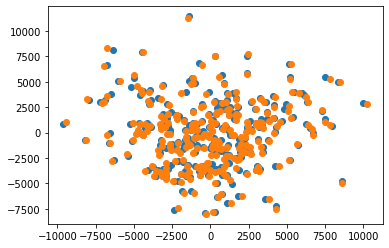

In [30]:
plt.scatter(activations_pca_embedding_reshaped[0,:,0],activations_pca_embedding_reshaped[0,:,1])
plt.scatter(activations_pca_embedding_reshaped[55,:,0],activations_pca_embedding_reshaped[55,:,1])

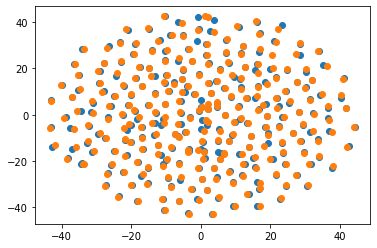

In [84]:
plt.scatter(activations_tsne_embedding_reshaped[0,:,0],activations_tsne_embedding_reshaped[0,:,1])
plt.scatter(activations_tsne_embedding_reshaped[900,:,0],activations_tsne_embedding_reshaped[900,:,1])

In [13]:
with open('noise_activation_embeddings_umap_0_0.2_1.8.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(activations_umap_embedding_reshaped, file)

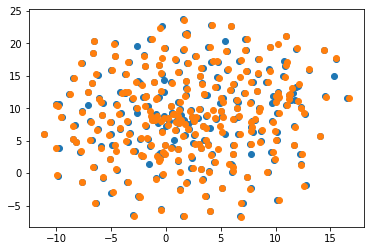

In [27]:
plt.scatter(activations_umap_embedding_reshaped[0,:,0],activations_umap_embedding_reshaped[0,:,1])
plt.scatter(activations_umap_embedding_reshaped[855,:,0],activations_umap_embedding_reshaped[855,:,1])

In [74]:
# model activations
df["bottleneck_activations_embedding"] = activations_tsne_embedding_reshaped.tolist()

In [62]:
# save everything to df

# prediction path
df["prediction_path"] = prediction_paths

# overall_iou
df["overall_iou"] = overall_ious

# iou by class
iou_class_df = pd.DataFrame(ious_by_class,columns = ["other_iou","road_iou","sidewalk_iou","vegetation_iou","sky_iou","car_iou"])
df = pd.concat((df,iou_class_df),axis=1)

In [63]:
noise_levels_full = [noise_levels[(index//100)] for index in range(len(df))]
df["noise_level"]=noise_levels_full

In [78]:
print(len(df.columns))
len(df_rearrange.columns)

26


26

In [129]:
len(df)

400

In [76]:
df_rearrange = df[['name',"noise_level",'dataset', 'image_path', 'label_path','prediction_path', 
                       'other_ratio', 'road_ratio', 'sidewalk_ratio','vegetation_ratio', 'sky_ratio', 'car_ratio', 
                       'simple_tsne_1','simple_tsne_2', 'meaningful_tsne_1', 'meaningful_tsne_2',"pca_1","pca_2",
       'bottleneck_activations_embedding', 'overall_iou', 'other_iou',
       'road_iou', 'sidewalk_iou', 'vegetation_iou', 'sky_iou', 'car_iou']]

In [79]:
df_rearrange

,name,noise_level,dataset,image_path,label_path,prediction_path,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,...,pca_1,pca_2,bottleneck_activations_embedding,overall_iou,other_iou,road_iou,sidewalk_iou,vegetation_iou,sky_iou,car_iou
0,0.jpeg,0.0,Cityscapes,dataset\noise_data\images\0\0.jpeg,dataset\cityscapes_labels_sample\0.jpeg,dataset\noise_data\predictions\0\0.jpeg,0.372009,0.320770,0.100510,0.183990,...,-13878.240511,-3285.104962,"[[-24.40557861328125, 16.901498794555664], [-1...",0.808624,0.662928,0.939133,0.512657,0.501233,0.874502,0.053785
1,1.jpeg,0.0,Cityscapes,dataset\noise_data\images\0\1.jpeg,dataset\cityscapes_labels_sample\1.jpeg,dataset\noise_data\predictions\0\1.jpeg,0.539703,0.414398,0.041168,0.000565,...,7664.169604,2740.275866,"[[-24.243043899536133, 17.648046493530273], [-...",0.700150,0.610244,0.741904,0.266866,0.001502,0.457912,0.000000
2,2.jpeg,0.0,Cityscapes,dataset\noise_data\images\0\2.jpeg,dataset\cityscapes_labels_sample\2.jpeg,dataset\noise_data\predictions\0\2.jpeg,0.462753,0.354187,0.029633,0.121323,...,-2078.566185,4442.207241,"[[-24.04833984375, 17.357967376708984], [-12.4...",0.906677,0.814527,0.970078,0.667676,0.833859,0.942492,0.195134
3,3.jpeg,0.0,Cityscapes,dataset\noise_data\images\0\3.jpeg,dataset\cityscapes_labels_sample\3.jpeg,dataset\noise_data\predictions\0\3.jpeg,0.425674,0.381119,0.065292,0.101120,...,458.471576,-3887.799220,"[[-25.07553482055664, 19.404129028320312], [-1...",0.918213,0.857314,0.945041,0.702885,0.778673,0.891587,0.271600
4,4.jpeg,0.0,Cityscapes,dataset\noise_data\images\0\4.jpeg,dataset\cityscapes_labels_sample\4.jpeg,dataset\noise_data\predictions\0\4.jpeg,0.400284,0.329453,0.090469,0.174393,...,-12533.626242,-1207.443328,"[[-23.370166778564453, 17.543115615844727], [-...",0.903854,0.776586,0.970622,0.839027,0.880338,0.272455,0.067600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,95.jpeg,1.8,Cityscapes,dataset\noise_data\images\1.8\95.jpeg,dataset\cityscapes_labels_sample\95.jpeg,dataset\noise_data\predictions\1.8\95.jpeg,0.558487,0.187454,0.000000,0.135422,...,9547.120854,5200.312182,"[[-25.05375099182129, 16.2783203125], [-11.118...",0.584198,0.479868,0.559818,0.000000,0.206933,0.498084,0.108259
996,96.jpeg,1.8,Cityscapes,dataset\noise_data\images\1.8\96.jpeg,dataset\cityscapes_labels_sample\96.jpeg,dataset\noise_data\predictions\1.8\96.jpeg,0.433578,0.403763,0.017990,0.086182,...,-4119.219402,-7089.826792,"[[-25.194746017456055, 18.61809539794922], [-1...",0.643616,0.481509,0.617667,0.095524,0.265837,0.736759,0.468750
997,97.jpeg,1.8,Cityscapes,dataset\noise_data\images\1.8\97.jpeg,dataset\cityscapes_labels_sample\97.jpeg,dataset\noise_data\predictions\1.8\97.jpeg,0.504059,0.320679,0.055939,0.010696,...,6131.457006,4063.156690,"[[-23.29961395263672, 17.390480041503906], [-1...",0.636627,0.531556,0.632178,0.179019,0.020934,0.469844,0.211550
998,98.jpeg,1.8,Cityscapes,dataset\noise_data\images\1.8\98.jpeg,dataset\cityscapes_labels_sample\98.jpeg,dataset\noise_data\predictions\1.8\98.jpeg,0.367798,0.340378,0.065277,0.166519,...,-3418.973475,-9316.225880,"[[-24.102874755859375, 18.36153793334961], [-1...",0.672958,0.485144,0.662340,0.433283,0.299666,0.602837,0.556140


In [77]:
df_rearrange.to_csv("noise_df.csv",index=True)